<a href="https://colab.research.google.com/github/GuidoGiacomoMussini/Image_BORN/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#born

In [ ]:
import scipy.sparse
import numpy
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import _check_sample_weight
from sklearn.utils.multiclass import unique_labels
from sklearn.exceptions import NotFittedError

class BornClassifier(ClassifierMixin, BaseEstimator):
    """Scikit-learn implementation of Born's Classifier

    This class is compatible with the [scikit-learn](https://scikit-learn.org) ecosystem.
    It supports both dense and sparse input and GPU-accelerated computing via [CuPy](https://cupy.dev).
    This classifier is suitable for classification with non-negative feature vectors.
    The data `X` are treated as unnormalized probability distributions.

    Parameters
    ----------
    a : float
        Amplitude. Must be strictly positive.
    b : float
        Balance. Must be non-negative.
    h : float
        Entropy. Must be non-negative.

    Attributes
    ----------
    gpu_ : bool
        Whether the model was fitted on GPU.
    corpus_ : array-like of shape (n_features_in_, n_classes)
        Fitted corpus.
    classes_ : ndarray of shape (n_classes,)
        Unique classes labels.
    n_features_in_ : int
        Number of features seen during `fit`.

    """

    def __init__(self, a=0.5, b=1., h=1.):
        self.a = a
        self.b = b
        self.h = h

    def fit(self, X, y, sample_weight=None):
        """Fit the classifier according to the training data X, y.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.
        y : array-like of shape (n_samples,) or (n_samples, n_classes)
            Target values. If 2d array, this is the probability
            distribution over the `n_classes` for each of the `n_samples`.
        sample_weight : array-like of shape (n_samples,)
            Array of weights that are assigned to individual samples.
            If not provided, then each sample is given unit weight.

        Returns
        -------
        self : object
            Returns the instance itself.

        """
        attrs = [
            "gpu_",
            "corpus_",
            "classes_",
            "n_features_in_"
        ]

        for attr in attrs:
            if hasattr(self, attr):
                delattr(self, attr)

        return self.partial_fit(X, y, classes=y, sample_weight=sample_weight)

    def partial_fit(self, X, y, classes=None, sample_weight=None):
        """Incremental fit on a batch of samples.

        This method is expected to be called several times consecutively on different chunks of a dataset so
        as to implement out-of-core or online learning.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.
        y : array-like of shape (n_samples,) or (n_samples, n_classes)
            Target values. If 2d array, this is the probability
            distribution over the `n_classes` for each of the `n_samples`.
        classes : array-like of shape (n_classes,)
            List of all the classes that can possibly appear in the `y` vector.
            Must be provided at the first call to `partial_fit`, can be omitted in subsequent calls.
        sample_weight : array-like of shape (n_samples,)
            Array of weights that are assigned to individual samples.
            If not provided, then each sample is given unit weight.

        Returns
        -------
        self : object
            Returns the instance itself.

        """
        X, y = self._sanitize(X, y)

        first_call = self._check_partial_fit_first_call(classes)
        if first_call:
            self.corpus_ = 0
            self.n_features_in_ = X.shape[1]

        if not self._check_encoded(y):
            y = self._one_hot_encoding(y)

        if sample_weight is not None:
            sample_weight = self._check_sample_weight(sample_weight, X)
            y = self._multiply(y, sample_weight.reshape(-1, 1))

        self.corpus_ += X.T @ self._multiply(y, self._power(self._sum(X, axis=1), -1))

        return self

    def predict(self, X):
        """Perform classification on the test data X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test data, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        Returns
        -------
        y : ndarray of shape (n_samples,)
            Predicted target classes for `X`.

        """
        proba = self.predict_proba(X)
        idx = self._dense().argmax(proba, axis=1)

        return self.classes_[idx]

    def predict_proba(self, X):
        """Return probability estimates for the test data X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test data, where `n_samples` is the number of samples
            and `n_features` is the number of features.

        Returns
        -------
        y : ndarray of shape (n_samples, n_classes)
            Returns the probability of the samples for each class in the model.
            The columns correspond to the classes in sorted order, as they appear in the attribute `classes_`.

        """
        self._check_fitted()

        X = self._sanitize(X)
        u = self._power(self._power(X, self.a) @ self._weights(), 1. / self.a)
        y = self._normalize(u, axis=1)

        if self._sparse().issparse(y):
            y = y.todense()

        return self._dense().asarray(y)

    def explain(self, X=None, sample_weight=None):
        r"""Global and local explanation

        For each test vector $`x`$, the $`a`$-th power of the unnormalized probability for the $`k`$-th class is
        given by the matrix product:

        ```math
        u_k^a = \sum_j W_{jk}x_j^a
        ```
        where $`W`$ is a matrix of non-negative weights that generally depends on the model's
        hyper-parameters ($`a`$, $`b`$, $`h`$). The classification probabilities are obtained by
        normalizing $`u`$ such that it sums up to $`1`$.

        This method returns global or local feature importance weights, depending on `X`:

        - When `X` is not provided, this method returns the global weights $`W`$.

        - When `X` is a single sample,
        this method returns a matrix of entries $`(j,k)`$ where each entry is given by $`W_{jk}x_j^a`$.

        - When `X` contains multiple samples,
        then the values above are computed for each sample and this method returns their weighted sum.
        By default, each sample is given unit weight.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Test data, where `n_samples` is the number of samples
            and `n_features` is the number of features. If not provided,
            then global weights are returned.
        sample_weight : array-like of shape (n_samples,)
            Array of weights that are assigned to individual samples.
            If not provided, then each sample is given unit weight.

        Returns
        -------
        E : array-like of shape (n_features, n_classes)
            Returns the feature importance for each class in the model.
            The columns correspond to the classes in sorted order, as they appear in the attribute `classes_`.

        """
        self._check_fitted()

        if X is None:
            return self._weights()

        X = self._sanitize(X)
        X = self._normalize(X, axis=1)
        X = self._power(X, self.a)

        if sample_weight is not None:
            sample_weight = self._check_sample_weight(sample_weight, X)
            X = self._multiply(X, sample_weight.reshape(-1, 1))

        return self._multiply(self._weights(), self._sum(X, axis=0).T)

    def _dense(self):
        return  numpy

    def _sparse(self):
        return scipy.sparse

    def _weights(self):
        P_jk = self.corpus_
        if self.b != 0:
            P_jk = self._multiply(P_jk, self._power(self._sum(self.corpus_, axis=0), -self.b))
        if self.b != 1:
            P_jk = self._multiply(P_jk, self._power(self._sum(self.corpus_, axis=1), self.b-1))

        W_jk = self._power(P_jk, self.a)
        if self.h != 0 and len(self.classes_) > 1:
            P_jk = self._normalize(P_jk, axis=1)
            H_j = 1 + self._sum(self._multiply(P_jk, self._log(P_jk)), axis=1) / self._dense().log(P_jk.shape[1])
            W_jk = self._multiply(W_jk, self._power(H_j, self.h))

        return W_jk

    def _sum(self, x, axis):
        if self._sparse().issparse(x):
            return x.sum(axis=axis)

        return self._dense().asarray(x).sum(axis=axis, keepdims=True)

    def _multiply(self, x, y):
        if self._sparse().issparse(x):
            return x.multiply(y).tocsr()

        if self._sparse().issparse(y):
            return y.multiply(x).tocsr()

        return self._dense().multiply(x, y)

    def _power(self, x, p):
        x = x.copy()

        if self._sparse().issparse(x):
            x.data = self._dense().power(x.data, p)

        else:
            nz = self._dense().nonzero(x)
            x[nz] = self._dense().power(x[nz], p)

        return x

    def _log(self, x):
        x = x.copy()

        if self._sparse().issparse(x):
            x.data = self._dense().log(x.data)

        else:
            nz = self._dense().nonzero(x)
            x[nz] = self._dense().log(x[nz])

        return x

    def _normalize(self, x, axis, p=1.):
        s = self._sum(x, axis)
        n = self._power(s, -p)

        return self._multiply(x, n)

    def _sanitize(self, X, y="no_validation"):
        only_X = isinstance(y, str) and y == "no_validation"

        gpu = self._check_gpu(X=X, y=y if not only_X else None)
        if getattr(self, "gpu_", None) is None:
            self.gpu_ = gpu

        elif self.gpu_ != gpu:
            raise ValueError(
                "X is not on the same device (CPU/GPU) as on last call "
                "to partial_fit, was: %r" % (self.gpu_, ))

        if not self.gpu_:
            kwargs = {
                "accept_sparse": "csr",
                "reset": False,
                "dtype": (numpy.float32, numpy.float64)
            }

            if only_X:
                X = super()._validate_data(X=X, **kwargs)

            else:
                X, y = super()._validate_data(X=X, y=y, multi_output=self._check_encoded(y), **kwargs)

            if not self._check_non_negative(X):
                raise ValueError("X must contain non-negative values")

        return X if only_X else (X, y)

    def _unique_labels(self, y):
        if self._check_encoded(y):
            return self._dense().arange(0, y.shape[1])

        elif self.gpu_:
            return self._dense().unique(y)

        else:
            return unique_labels(y)

    def _one_hot_encoding(self, y):
        classes = self.classes_
        n, m = len(y), len(classes)

        if self.gpu_:
            y = y.get()
            classes = classes.get()

        unseen = set(y) - set(classes)
        if unseen:
            raise ValueError(
                "`classes=%r` were not allowed on first call "
                "to partial_fit" % (unseen, ))

        idx = {c: i for i, c in enumerate(classes)}
        col = self._dense().array([idx[c] for c in y])
        row = self._dense().array(range(0, n))
        val = self._dense().ones(n)

        return self._sparse().csr_matrix((val, (row, col)), shape=(n, m))

    def _check_encoded(self, y):
        return self._sparse().issparse(y) or (getattr(y, "ndim", 0) == 2 and y.shape[1] > 1)

    def _check_non_negative(self, X):
        if self._sparse().issparse(X):
            if self._dense().any(X.data < 0):
                return False

        elif self._dense().any(X < 0):
            return False

        return True

    def _check_sample_weight(self, sample_weight, X):
        if self.gpu_:
            return sample_weight

        return _check_sample_weight(sample_weight=sample_weight, X=X)

    def _check_partial_fit_first_call(self, classes):
        if getattr(self, "classes_", None) is None and classes is None:
            raise ValueError("classes must be passed on the first call to partial_fit")

        elif classes is not None:
            classes = self._unique_labels(classes)

            if getattr(self, "classes_", None) is not None:
                if not self._dense().array_equal(self.classes_, classes):
                    raise ValueError(
                        "`classes=%r` is not the same as on last call "
                        "to partial_fit, was: %r" % (classes, self.classes_))

            else:
                self.classes_ = classes
                return True

        return False

    def _check_gpu(self, X, y=None):
        return False

    def _check_fitted(self):
        if getattr(self, "corpus_", None) is None:
            raise NotFittedError(
                f"This {self.__class__.__name__} instance is not fitted yet. "
                "Call 'fit' with appropriate arguments before using this estimator")

    def _more_tags(self):
        return {
            'requires_y': True,
            'requires_positive_X': True,
            'X_types': ['2darray', 'sparse'],
            '_xfail_checks': {
                'check_classifiers_classes':
                    'This is a pathological data set for BornClassifier. '
                    'For some specific cases, it predicts less classes than expected',
                'check_classifiers_train':
                    'Test fails because of negative values in X'
            }
        }

# Functions

In [ ]:
def build_vocab(features_train, k):

  features_reshaped = features_train.reshape(-1, features_train.shape[-1])

  minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, batch_size=100, n_init = 3)
  minibatch_kmeans.fit(features_reshaped)

  visual_vocab = minibatch_kmeans.cluster_centers_

  return visual_vocab

def build_histogram(x_train, features_train, k, visual_vocab):
  histograms = np.zeros((len(x_train), k))  # Inizializza gli istogrammi

  # Costruisci l'istogramma per ogni immagine
  for i in range(len(x_train)):
      distances = cdist(features_train[i].reshape(-1, features_train.shape[-1]), visual_vocab)
      closest_clusters = np.argmin(distances, axis=1)
      for cluster_idx in closest_clusters:
          histograms[i][cluster_idx] += 1

  return histograms

In [ ]:
def try_models(x_train, x_test, features_train, features_test, k_list):
  accuracies, cf = [], {}

  for k in k_list:
    #build vocabulary
    visual_vocab = build_vocab(features_train, k)
    #define the histograms
    train_histograms = build_histogram(x_train, features_train, k, visual_vocab)
    test_histograms = build_histogram(x_test, features_test, k, visual_vocab)
    #train
    classifier = BornClassifier()
    classifier.fit(train_histograms, y_train)
    #test
    preds = classifier.predict(test_histograms)

    accuracies.append((k, sklearn.metrics.accuracy_score(y_true, preds)))
    cf[k] = confusion_matrix(y_true, preds)

  return accuracies, cf

#data

In [ ]:
from keras.datasets import cifar10
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical
import seaborn as sns
from tqdm.notebook import tqdm as progress_bar
import sklearn
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

# CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#normalize
x_train= x_train.astype('float32') / 255.0
x_test= x_test.astype('float32') / 255.0

#one hot
y_comp = y_train  #per comparazione
y_train = to_categorical(y_train)

#array -> list
y_comp = [y[0] for y in y_comp.tolist()]
y_true = [y[0] for y in y_test.tolist()]

In [ ]:
#ISIC BINARY
# path = '/content/drive/MyDrive/Colab Notebooks/Tesi/MEDICAL IMAGING/'
# isic_m = 'Skin_Cancer_64.h5'
# isic_b = 'Skin_Cancer_binary_64.h5'

# df_isic_b = pd.read_hdf(path+isic_b, 'df')
# df_isic_b.name = 'isic_binary'

# df = df_isic_b

# #trasformo ISIC in formato coerente:
# df['image'] = df['image'].apply(lambda img: img.astype('float32') / 255.0)
# df['label'] = to_categorical(df['label'])
# x = np.array(df['image'].tolist())
# y = np.array(df['label'].tolist())
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# y_true = [np.argmax(y) for y in y_test]

In [ ]:
dim = x_train.shape[1]

# pretrained models

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.densenet import DenseNet121
from keras.applications.efficientnet import EfficientNetB0

vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(dim, dim, 3))

resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(dim, dim, 3))

mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(dim, dim, 3))

densenet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(dim, dim, 3))

efficientnetb0_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(dim, dim, 3))

models = [vgg16_model, resnet50_model, mobilenet_model, densenet121_model, efficientnetb0_model]

# Compare models and vocab size

In [ ]:
model_acc, conf_m = [], []
k_list = [10, 50, 100, 500, 1000]
for model in progress_bar(models):
  features_train = model.predict(x_train)
  features_test = model.predict(x_test)
  accuracies, cf= try_models(x_train, x_test, features_train, features_test, k_list)
  model_acc.append((model.name, accuracies))
  conf_m.append((model.name, cf))

In [ ]:
model_acc

In [ ]:
conf_m

In [ ]:
sns.heatmap(conf_m[3][1][1000], annot=True, fmt=".0f")

# Compare BORN with other classifiers

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

classifiers = {
    "RandomForest": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "MultinomialNB": MultinomialNB(),
    "KNeighbors": KNeighborsClassifier(),
    "SVC": SVC(),
    "DecisionTree": DecisionTreeClassifier(),
    "BORN": BornClassifier()
}

In [ ]:
result_dict = {}
k = 100 #set K

for model in progress_bar(models):
  classifier_dict = {}
  #extract the features
  features_train = model.predict(x_train)
  features_test = model.predict(x_test)
  #vocab
  visual_vocab = build_vocab(features_train, k)
  #define the histograms
  train_histograms = build_histogram(x_train, features_train, k, visual_vocab)
  test_histograms = build_histogram(x_test, features_test, k, visual_vocab)
  for name, classifier in classifiers.items():
    #train
    classifier.fit(train_histograms, y_comp)
    #test
    preds = classifier.predict(test_histograms)

    classifier_dict[name] = sklearn.metrics.accuracy_score(y_true, preds)

  result_dict[model.name] = classifier_dict

In [ ]:
result_dict

{'vgg16': {'RandomForest': 0.3139,
  'LogisticRegression': 0.3139,
  'MultinomialNB': 0.3139,
  'KNeighbors': 0.2327,
  'SVC': 0.3139,
  'DecisionTree': 0.3139,
  'BORN': 0.3139},
 'resnet50': {'RandomForest': 0.2517,
  'LogisticRegression': 0.2522,
  'MultinomialNB': 0.2517,
  'KNeighbors': 0.1671,
  'SVC': 0.2513,
  'DecisionTree': 0.2517,
  'BORN': 0.2517},
 'mobilenet_1.00_224': {'RandomForest': 0.2034,
  'LogisticRegression': 0.2028,
  'MultinomialNB': 0.2027,
  'KNeighbors': 0.1436,
  'SVC': 0.2027,
  'DecisionTree': 0.2027,
  'BORN': 0.2027},
 'densenet121': {'RandomForest': 0.3434,
  'LogisticRegression': 0.3434,
  'MultinomialNB': 0.3423,
  'KNeighbors': 0.2623,
  'SVC': 0.3423,
  'DecisionTree': 0.3423,
  'BORN': 0.3423},
 'efficientnetb0': {'RandomForest': 0.2193,
  'LogisticRegression': 0.2199,
  'MultinomialNB': 0.22,
  'KNeighbors': 0.1421,
  'SVC': 0.2199,
  'DecisionTree': 0.22,
  'BORN': 0.22}}

In [ ]:
confusion_matrix(y_true, preds)

array([[249, 135,  35,  17, 111,  17,  52, 104, 204,  76],
       [ 68, 353,   5,  28,  46,  13,  70, 102, 138, 177],
       [121,  97,  64,  52, 207,  29, 164, 116,  81,  69],
       [108,  93,  30, 109, 162,  28, 145, 177,  66,  82],
       [ 86,  85,  59,  45, 301,   9, 162, 104,  89,  60],
       [ 88, 123,  33, 112, 113,  35, 140, 156, 101,  99],
       [ 65, 103,  44,  56, 189,  13, 253, 119,  84,  74],
       [ 52, 144,  12,  42, 107,  32, 124, 282,  71, 134],
       [143, 158,  17,  30, 154,  12,  55,  40, 326,  65],
       [ 85, 299,   7,  30,  53,  17,  63, 142,  76, 228]])

In [ ]:
#results
df = pd.DataFrame(result_dict).T
df = df.reset_index().melt(id_vars='index', var_name='Classifier', value_name='Accuracy')
df.rename(columns={'index': 'Model'}, inplace=True)

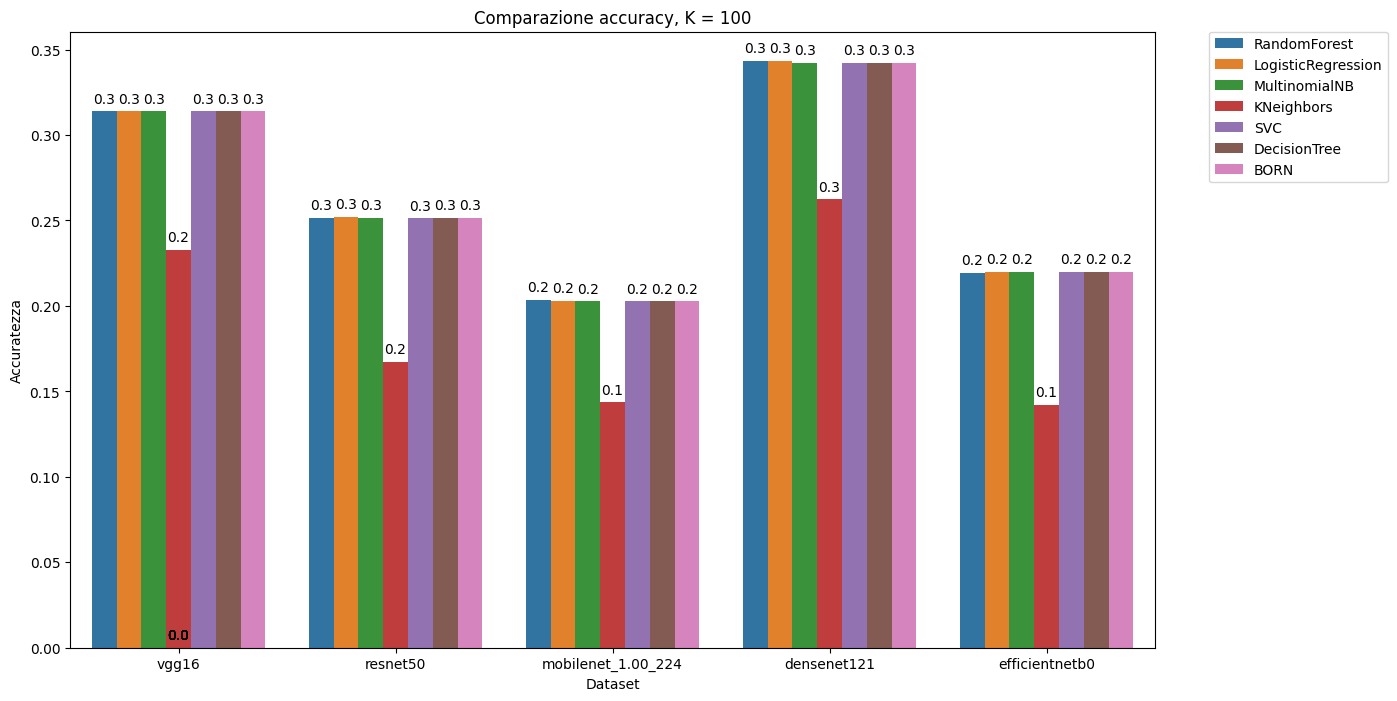

In [ ]:
#PLOT
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Model', y='Accuracy', hue='Classifier', data=df)

plt.title('Comparazione accuracy, K = 100')
plt.xlabel('Dataset')
plt.ylabel('Accuratezza')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()